In [46]:
from IPython.display import clear_output

# !pip install transformers
# !pip install datasets
# !pip install -q sentencepiece
# !pip install rouge-score

clear_output()

In [17]:
import os
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

import tensorflow as tf
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration

# Load Data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "/content/gdrive/MyDrive/Classes/W266_NLP/w266_reddit_summarization/data/tensorflow_datasets/reddit/1.0.0"
os.chdir(data_dir)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
file_names = os.listdir(data_dir)
metadata_files = [i for i in file_names if re.search('^(?!reddit-train)', i)]

data_files = np.array([i for i in file_names if re.search('^reddit-train', i)])
split_ind = np.array([int(x[22:27]) % 5 for x in data_files])
test = data_files[split_ind == 0]
train = data_files[split_ind != 0]

In [5]:
def parse_file(serialized_example):

  file_scruct = {
      'author': tf.io.FixedLenFeature([], tf.string),
      'body': tf.io.FixedLenFeature([], tf.string),
      'content': tf.io.FixedLenFeature([], tf.string),
      'id': tf.io.FixedLenFeature([], tf.string),
      'normalizedBody': tf.io.FixedLenFeature([], tf.string),
      'subreddit': tf.io.FixedLenFeature([], tf.string),
      'subreddit_id': tf.io.FixedLenFeature([], tf.string),
      'summary': tf.io.FixedLenFeature([], tf.string),
  }

  example1 = tf.io.parse_single_example(serialized_example, file_scruct)
  return example1

# parse (only use a section of the data)
data_section = 10
dataset = tf.data.TFRecordDataset(data_files[:data_section]).map(parse_file)
data_dict = {'id': [], 'author': [], 'subreddit': [], 'content': [], 'summary': []}
keys_to_parse = ['id', 'author', 'subreddit', 'content', 'summary']


for i, item in enumerate(tqdm(dataset)):
  if i % 500000 == 0:
    print(f"{i} files parsed")
  for key1 in keys_to_parse:
    data_dict[key1].append(item[key1])

269it [00:00, 1346.64it/s]

0 files parsed


150324it [01:21, 1835.10it/s]


# EDA

In [11]:
def count_vocab():
  l = []
  for i in range(len(data_dict['content'])):
    l.append(data_dict['content'][i].numpy().decode().split(" ")[0])
    l.append(data_dict['summary'][i].numpy().decode().split(" ")[0])
    if i % 10000 == 0:
      l = list(set(l))
  
  return len(set(l))

  
vocab_size = count_vocab()
vocab_size

31269

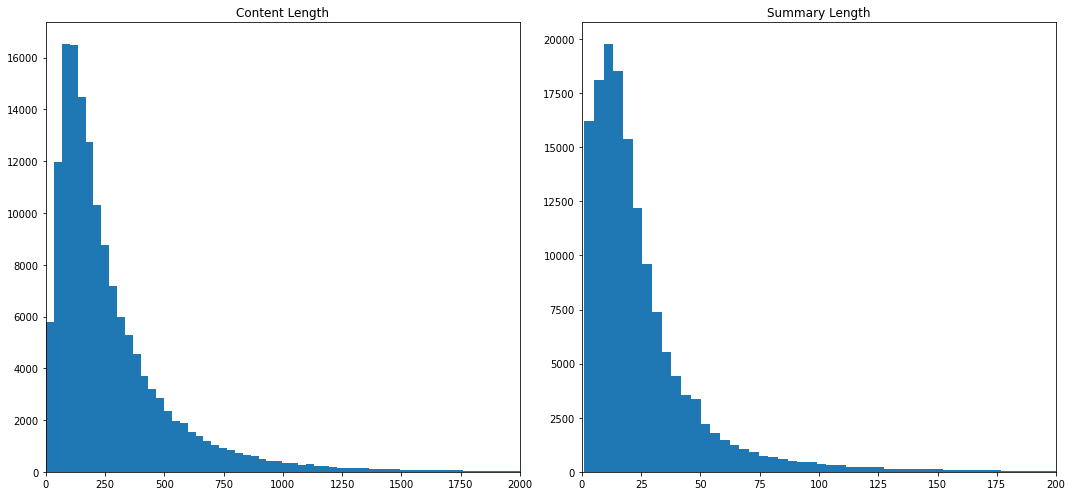

In [12]:
content_len = [len(data_dict['content'][i].numpy().decode().split(" ")) for i in range(len(data_dict['id']))]
summary_len = [len(data_dict['summary'][i].numpy().decode().split(" ")) for i in range(len(data_dict['id']))]

fig, ax = plt.subplots(1, 2, figsize = (15,7)) 

ax[0].hist(content_len, bins=300)
ax[0].set_xlim(0, 2000)
ax[0].title.set_text("Content Length")

ax[1].hist(summary_len, bins=500)
ax[1].set_xlim(0, 200)
ax[1].title.set_text("Summary Length")

fig.tight_layout()

# Pegasus

In [ ]:
# pegasus fine tune

model = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-reddit_tifu", from_pt=True)
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-reddit_tifu")

# other pegasus ones to try:
## google/pegasus-reddit_tifu (have to include from_pt=True)
## google/pegasus-xsum
## google/pegasus-large

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFPegasusForConditionalGeneration.

Some weights or buffers of the TF 2.0 model TFPegasusForConditionalGeneration were not initialized from the PyTorch model and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

# T5

In [13]:
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
T5_model = TFT5ForConditionalGeneration.from_pretrained("google/t5-v1_1-base")
tokenizer = T5Tokenizer.from_pretrained("google/t5-v1_1-base")

Downloading:   0%|          | 0.00/605 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/945M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at google/t5-v1_1-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

In [14]:
T5_model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (TFSharedEmbeddings)  multiple                 24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  84954240  
                                                                 
 decoder (TFT5MainLayer)     multiple                  113275008 
                                                                 
 lm_head (Dense)             multiple                  24674304  
                                                                 
Total params: 247,577,856
Trainable params: 247,577,856
Non-trainable params: 0
_________________________________________________________________


In [20]:
# pprint(data_dict['content'][0].numpy().decode())
# pprint(data_dict['summary'][0].numpy().decode())

In [22]:
# baseline no fine tuning
#Inputs for T5 Model
inputs = tokenizer(
    'summarize: ' + data_dict['content'][0].numpy().decode()
    ,max_length=1024, truncation=True, return_tensors="tf")

# Generate Summary
summary_ids = T5_model.generate(inputs["input_ids"], 
                             num_beams=1,
                              no_repeat_ngram_size=1,
                              min_length=20,
                              max_length=50)
pprint(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0], compact=True)

(', and a few other things. the NBA draft lottery you have your own team to '
 'cheer for! Steven Adams (Pitt) is one of them: Sean that will be has it we '
 'go')


In [45]:
# fine tune
#data_dict['content']

In [ ]:
# i don think this works
# t5token_train = [tokenizer(
#     'summarize: ' + data_dict['content'][i].numpy().decode()
#     ,max_length=1024, truncation=True, return_tensors="tf") for i in range(10)]

# t5token_val = [tokenizer(
#     data_dict['summary'][i].numpy().decode()
#     ,max_length=1024, truncation=True, return_tensors="tf") for i in range(10)]

In [41]:
# create encoder
def encode(x,y, encoder_max_len=1500, decoder_max_len=150, tokenizer=tokenizer):
  # x = data_dict['content'][0].numpy().decode()
  # y = data_dict['summary'][0].numpy().decode()

  encoder_inputs = tokenizer('summarize: ' + x, max_length=1024, truncation=True, return_tensors="tf")
  input_ids = encoder_inputs['input_ids'][0]
  input_attention = encoder_inputs['attention_mask'][0]

  decoder_inputs = tokenizer("context: " + y, max_length=1024, truncation=True, return_tensors="tf")
  target_ids = decoder_inputs['input_ids'][0]
  target_attention = decoder_inputs['attention_mask'][0]

  outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 'labels':target_ids, 'decoder_attention_mask':target_attention}
  return outputs

# encode
train_df = [encode(x=data_dict['content'][i].numpy().decode(), y=data_dict['summary'][i].numpy().decode(), tokenizer=tokenizer) for i in range(10)]
#valid_df = [encode()]

In [58]:
# create encoder (try again using .map)
def encode(x,y, encoder_max_len=1500, decoder_max_len=150, tokenizer=tokenizer):
  # x = data_dict['content'][0].numpy().decode()
  # y = data_dict['summary'][0].numpy().decode()

  encoder_inputs = tokenizer('summarize: ' + x, max_length=1024, truncation=True, padding='max_length', return_tensors="tf")
  input_ids = encoder_inputs['input_ids'][0]
  input_attention = encoder_inputs['attention_mask'][0]

  decoder_inputs = tokenizer("context: " + y, max_length=1024, truncation=True, padding='max_length', return_tensors="tf")
  target_ids = decoder_inputs['input_ids'][0]
  target_attention = decoder_inputs['attention_mask'][0]

  outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 'labels':target_ids, 'decoder_attention_mask':target_attention}
  return outputs

# encode
train_df = [encode(x=data_dict['content'][i].numpy().decode(), y=data_dict['summary'][i].numpy().decode(), tokenizer=tokenizer) for i in range(10)]
#valid_df = [encode()]

In [62]:
train_tf_input_ids = tf.stack([train_df[i]['input_ids'] for i in range(10)])
train_tf_label_ids = tf.stack([train_df[i]['labels'] for i in range(10)])

In [64]:
# try to fine tune
T5_model_finetune = T5_model
T5_model_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy') ],
)

T5_model_finetune.fit(x=train_tf_input_ids,y=train_tf_label_ids,epochs=2)

#T5_model_finetune.fit((t5token_train, t5token_val), epochs=3)

Epoch 1/2


ValueError: ignored